# Quick Start Example of APT_Ninja

## Table of contents

[**Step 1 Read pos File**](#step1)

[**Step 2 Slice and Save**](#step2) 

[**Step 3 Run Segmentation**](#step3)

[**Step 4 Map Masks to Slices**](#step4)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[**Visualize Slice and Mask**](#visualize_middle_slice)

[**Step 5 Reconstruct 3-D clusters**](#step5)

## Step 1 Read pos File <a class="anchor" id="step1"></a>

In [17]:
# === USER INPUT ===
folder_path = r'./' # Path to the folder containing your .pos file and related data, ./' for current directory
dataset_name = '12cr.pos' # Name of the .pos file to process 
output_name = '12cr.txt' # Desired name for the output file
Cr=12 # This value is used to name output folders like: test_{Cr}_{direction}_{thickness}
direction = 'xy' #Slicing direction: choose from 'xy', 'yz', or 'xz'

In [18]:
import os
import glob
import pickle
import cv2
import h5py
import torch
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from ultralytics import YOLO

In [19]:
# step 1: Read pos File
def open_pos(file_path):
    """Reads a .pos file and returns xyz for Cr atoms (mass 24.9360–26.7840)."""
    with open(file_path, 'rb') as f:
        data = np.fromfile(f, dtype='>f4') # big-endian float32
    pos = data.reshape(-1, 4)
    mask = (pos[:, 3] >= 24.9360) & (pos[:, 3] <= 26.7840)
    pos = pos[mask, :3]
    return pos


print(f'⏳ Reading pos file')
file_path = os.path.join(folder_path, dataset_name)
pos_data = open_pos(file_path)
np.savetxt(os.path.join(folder_path, output_name), pos_data, fmt='%.6f')
print(f"✅ Finished reading {dataset_name} and saved to {output_name}")

⏳ Reading pos file
✅ Finished reading 12cr.pos and saved to 12cr.txt


## Step 2 Slice and Save <a class="anchor" id="step2"></a>

In [28]:
# step2: Slice and Save
def slice_and_save(pos_data, Cr, direction, thickness):
    """
    Slices 3D point data along a given direction and saves images and .mat files.

    Parameters:
        pos_data (np.ndarray): Nx3 array of 3D points.
        Cr (int): Critical radius value (used in folder naming).
        direction (str): Slicing direction ('xy', 'yz', or 'xz').
        thickness (float): Thickness of each slice.
    """
    print(f'⏳ Slicing in {direction} direction...')
    foldername = f"test_{Cr}_{direction}_{thickness}"
    os.makedirs(foldername, exist_ok=True)

    linewidth, alpha = 2, 1
    imgind = 1

    # Determine slicing axis and projection axes
    if direction == 'xy':
        slice_axis = 2
        proj_axes = (0, 1)
    elif direction == 'yz':
        slice_axis = 0
        proj_axes = (1, 2)
    elif direction == 'xz':
        slice_axis = 1
        proj_axes = (0, 2)
    else:
        raise ValueError("Invalid direction. Choose from 'xy', 'yz', or 'xz'.")

    z_min, z_max = np.min(pos_data[:, slice_axis]), np.max(pos_data[:, slice_axis])

    for height in np.arange(round(z_min + 5), round(z_max - 5), thickness):
        mask = np.abs(pos_data[:, slice_axis] - height) < thickness / 2
        slice_points = pos_data[mask]
        if slice_points.shape[0] == 0:
            imgind += 1
            continue

        # Normalize projection axes
        d = slice_points[:, list(proj_axes)].copy()
        d_min, d_max = np.min(d, axis=0), np.max(d, axis=0)
        d = (d - d_min) / (d_max - d_min + 1e-8)  # avoid division by zero

        fig = plt.figure(figsize=(10.58, 10.58), dpi=96)
        ax = plt.gca()
        ax.scatter(d[:, 0], d[:, 1], s=4,
                   facecolors=[0.7176, 0.2745, 1],
                   edgecolors=[0.7176, 0.2745, 1],
                   linewidths=linewidth, alpha=alpha)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis('off')
        ax.set_aspect('equal')
        ax.set_position([0, 0, 1, 1])

        img_path = os.path.join(foldername, f"test{imgind}.jpg")
        plt.savefig(img_path, dpi=96, bbox_inches='tight', pad_inches=0)
        plt.close(fig)

        sio.savemat(os.path.join(foldername, f"test{imgind}.mat"),
                    {'slice_points': slice_points})
        imgind += 1

    print(f"✅ Slices (1015×1015 px) saved to: {foldername}")
    
thickness = 0.2 # thickness of the slicing plane (in the same units as your data, e.g., nm)
slice_and_save(pos_data=pos_data, Cr=Cr, direction=direction, thickness=thickness)

⏳ Slicing in xy direction...
✅ Slices (1015×1015 px) saved to: test_12_xy_0.2


## Step 3 Run Segmentation <a class="anchor" id="step3"></a>

In [23]:
# step3: Run Segmentation
def run_segmentation(foldername, Cr, thickness, direction, model_path):
    """
    Runs YOLO segmentation on image slices and saves masks to .mat files.

    Parameters:
        foldername (str): Folder containing the test images.
        Cr (int): Critical radius value (used in output folder naming).
        thickness (float): Slice thickness (used in output folder naming).
        direction (str): Slicing direction ('xy', 'yz', or 'xz').
        model_path (str): Path to the YOLO model.
    """
    print(f'⏳ Segmentation in progress on {direction} direction slices...')

    image_files = glob.glob(f"./{foldername}/test*.jpg")
    output_dir = f"./results_{Cr}_{thickness:.1f}"
    os.makedirs(output_dir, exist_ok=True)

    model = YOLO(model_path)
    conf_thresholds = 0.25

    for image_file in image_files:
        results = model(image_file, conf=conf_thresholds, verbose=False)
        result = results[0]
        orig_img = result.orig_img

        if result.masks is None or not hasattr(result.masks, 'data'):
            continue

        masks = [mask.cpu().numpy() for mask in result.masks.data]
        masks_resized = [cv2.resize(mask, (orig_img.shape[1], orig_img.shape[0])) for mask in masks]

        image_number = os.path.basename(image_file).split('.')[0].split('test')[-1]
        save_path = os.path.join(output_dir, f'results_{image_number}_{direction}.mat')
        sio.savemat(save_path, {'orig_img': orig_img, 'masks': masks_resized})

    print("✅ Segmentation completed.")

foldername = f"test_{Cr}_{direction}_{thickness}"
model_path='./Model Training/thick2.pt'
run_segmentation(foldername=foldername, Cr=Cr, thickness=thickness, direction=direction, model_path=model_path)

⏳ Segmentation in progress on xy direction slices...
✅ Segmentation completed.


## Step 4 Map Masks to Slices <a class="anchor" id="step4"></a>

In [24]:
# step4: Map Masks to Slices
def map_masks_to_slices(foldername, output_dir, direction):
    """
    Aligns segmentation masks with original 3D slices.

    Parameters:
        foldername (str): Folder containing original slice .mat files.
        output_dir (str): Folder containing segmentation result .mat files.
        direction (str): Slicing direction used ('xy', 'yz', or 'xz').

    Returns:
        slices (list of np.ndarray): List of 2D slices with segmentation labels.
    """
    print(f'⏳ Aligning segmentation masks with original slices...')

    
# Determine slicing axis and projection axes
    if direction == 'xy':
        slice_axis = 2
        proj_axes = (0, 1)
    elif direction == 'yz':
        slice_axis = 0
        proj_axes = (1, 2)
    elif direction == 'xz':
        slice_axis = 1
        proj_axes = (0, 2)
    else:
        raise ValueError("Invalid direction. Choose from 'xy', 'yz', or 'xz'.")


    jpg_files = glob.glob(os.path.join(foldername, 'test*.jpg'))
    num_files = len(jpg_files)

    slices = []

    for slice_idx in range(1, num_files + 1):
        # Load segmentation result
        seg_path = os.path.join(output_dir, f'results_{slice_idx}_{direction}.mat')
        if not os.path.isfile(seg_path):
            continue

        seg_data = sio.loadmat(seg_path)
        if 'orig_img' not in seg_data or 'masks' not in seg_data:
            continue
        img = seg_data['orig_img']
        masks = seg_data['masks']
        mask = np.transpose(masks, (1, 2, 0))
        mask = np.sum(mask, axis=2)

        # Load original slice points
        orig_path = os.path.join(foldername, f'test{slice_idx}.mat')
        if not os.path.isfile(orig_path):
            continue

        orig_data = sio.loadmat(orig_path)
        if 'slice_points' not in orig_data:
            continue

        d = orig_data['slice_points']
        slice_segmented = d.copy()
        
        
        d_min, d_max = np.min(d[:, proj_axes], axis=0), np.max(d[:, proj_axes], axis=0)
        d_norm = (d[:, proj_axes] - d_min) / (d_max - d_min + 1e-8)


        mapped_d = np.hstack((d.copy(), np.zeros((d.shape[0], 1))))
        
        for i in range(mapped_d.shape[0]):
            x, y = d_norm[i, 0], d_norm[i, 1]
            x_pixel = int(round(x * (mask.shape[1] - 1)))
            y_pixel = int(round((1 - y) * (mask.shape[0] - 1)))  # Flip y-axis
            if (0 <= y_pixel < mask.shape[0]) and (0 <= x_pixel < mask.shape[1]):
                mapped_d[i, 3] = 1 if mask[y_pixel, x_pixel] >= 1 else 0


        slice_segmented = np.hstack((slice_segmented, mapped_d[:, 3:4]))
        slices.append(slice_segmented)

    print(f"✅ A total of {num_files} segmented masks have been aligned with the original slices on {direction} direction.")
    return slices, num_files

output_dir = f"./results_{Cr}_{thickness:.1f}"
slices, num_files = map_masks_to_slices(foldername=foldername, output_dir=output_dir, direction=direction)

⏳ Aligning segmentation masks with original slices...
✅ A total of 370 segmented masks have been aligned with the original slices on xy direction.


### Visualize Slice and Mask <a class="anchor" id="visualize_middle_slice"></a>


🎨 An example segmentation result on the middle slice of the dataset.


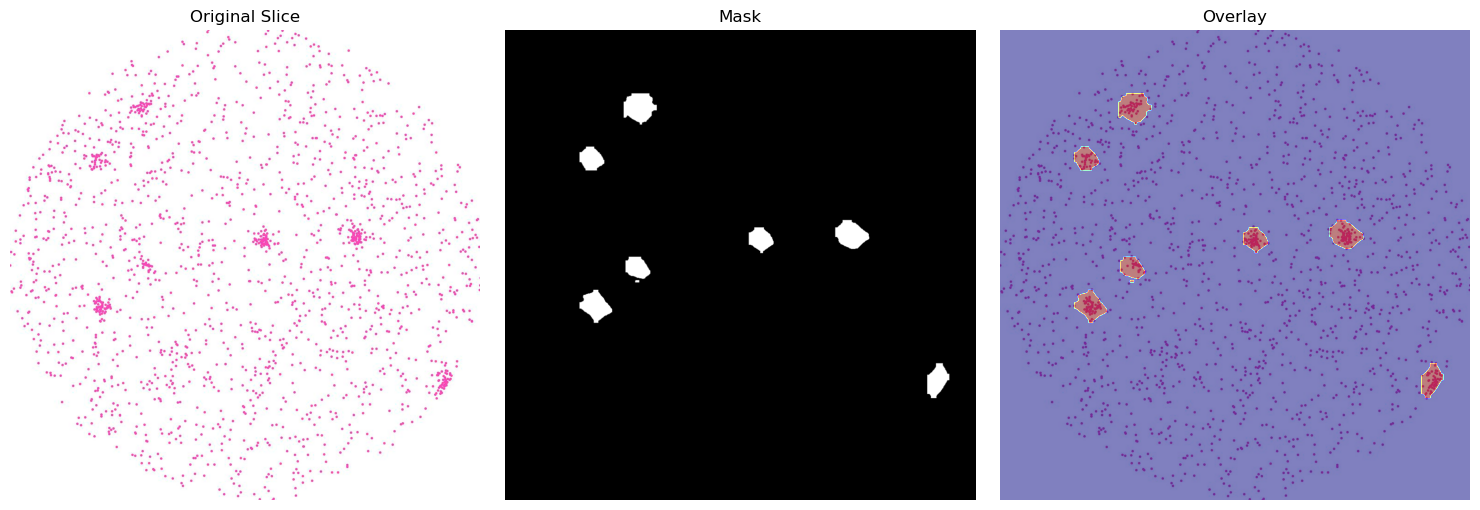

In [25]:
# Visualize Slice and Mask
def visualize_middle_slice(Cr, thickness, num_files, direction):
    """
    Visualizes the segmentation result on the middle slice.

    Parameters:
        Cr (int): Critical radius value.
        thickness (float): Slice thickness.
        num_files (int): Total number of slices.
        direction (str): Slicing direction ('xy', 'yz', or 'xz').
    """
    print()
    print(f"🎨 An example segmentation result on the middle slice of the dataset.")

    middle_idx = num_files // 2

    # Construct paths
    detecpath = f'./results_{Cr}_{thickness:.1f}'
    mask_path = os.path.join(detecpath, f'results_{middle_idx}_{direction}.mat')

    origpath = f'./test_{Cr}_{direction}_{thickness:.1f}'
    img_path = os.path.join(origpath, f'test{middle_idx}.mat')

    # Load data
    if not os.path.isfile(mask_path) or not os.path.isfile(img_path):
        print("❌ Middle slice files not found.")
        return

    mask_data = sio.loadmat(mask_path)
    img_data = sio.loadmat(img_path)

    if 'orig_img' in mask_data and 'masks' in mask_data and 'slice_points' in img_data:
        orig_img = mask_data['orig_img']
        masks = mask_data['masks']
        mask = np.transpose(masks, (1, 2, 0))
        mask = np.sum(mask, axis=2)

        # Plot
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        axs[0].imshow(orig_img, cmap='gray')
        axs[0].set_title('Original Slice')
        axs[0].axis('off')

        axs[1].imshow(mask, cmap='gray')
        axs[1].set_title('Mask')
        axs[1].axis('off')

        axs[2].imshow(orig_img, cmap='gray')
        axs[2].imshow(mask, cmap='jet', alpha=0.5)
        axs[2].set_title('Overlay')
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("❌ Required data not found in .mat files.")

    print()

visualize_middle_slice(Cr=Cr, thickness=thickness, num_files=num_files, direction=direction)


## Step 5 Reconstruct 3-D clusters <a class="anchor" id="step5"></a>


🎨 3D reconstruction based on the slices on the xy direction.


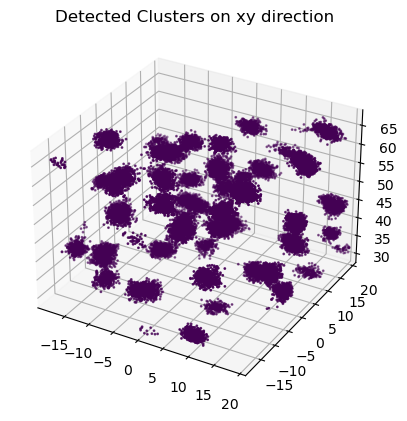

In [26]:
# Step 5: Reconstruct 3-D clusters
def reconstruct_3d_clusters(slices, Cr, direction):
    """
    Reconstructs and visualizes 3D clusters from segmented slices.

    Parameters:
        slices (list of np.ndarray): List of 2D slices with segmentation labels.
        Cr (int): Critical radius value (used to determine zoom level).
        direction (str): Slicing direction (for display/logging purposes).
    """
    print()
    print(f"🎨 3D reconstruction based on the slices on the {direction} direction.")

    if not slices:
        print("❌ No slices provided for reconstruction.")
        return

    detection = np.vstack(slices)
    slice2 = detection[detection[:, 3] > 0, :]

    # Determine the range based on Cr
    if Cr == 9:
        delta = 30
    elif Cr == 12:
        delta = 20
    elif Cr in [15, 18]:
        delta = 15
    else:
        raise ValueError("Unsupported value for Cr. Expected 9, 12, 15, or 18.")

    # Compute center and limits
    x_center, y_center, z_center = np.mean(slice2[:, 0]), np.mean(slice2[:, 1]), np.mean(slice2[:, 2])
    xlim = [x_center - delta, x_center + delta]
    ylim = [y_center - delta, y_center + delta]
    zlim = [z_center - delta, z_center + delta]

    # Apply spatial filtering
    mask = (
        (slice2[:, 0] >= xlim[0]) & (slice2[:, 0] <= xlim[1]) &
        (slice2[:, 1] >= ylim[0]) & (slice2[:, 1] <= ylim[1]) &
        (slice2[:, 2] >= zlim[0]) & (slice2[:, 2] <= zlim[1])
    )
    slice3 = slice2[mask]

    # Plot 3D scatter
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(slice3[:, 0], slice3[:, 1], slice3[:, 2], c=slice3[:, 3], s=1, cmap='viridis')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)
    plt.title(f'Detected Clusters on {direction} direction')
    plt.show()

reconstruct_3d_clusters(slices=slices, Cr=Cr, direction=direction)